In [1]:
import sys
import numpy as np
import glob
from matplotlib import pyplot as plt
import os
import datetime
from collections import Counter 
import cv2
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization,LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.python.keras.callbacks import TensorBoard
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

%load_ext tensorboard
!rm -rf ./logs/ 
tensorflow.__version__

Found GPU at: /device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4684684477011742967
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1416432435
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14563689999340160938
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


'rm' is not recognized as an internal or external command,
operable program or batch file.


'2.1.0'

In [2]:
root = "D:/imageData/"



train_dir = os.path.join(root, 'train')
valdation_dir = os.path.join(root, 'validation')

train_fist_dir = os.path.join(train_dir, 'fist_train')  
train_palm_dir = os.path.join(train_dir, 'palm_train')  
val_fist_dir  = os.path.join(valdation_dir, 'fist_val')  
val_palm_dir = os.path.join(valdation_dir, 'palm_val')  

In [3]:
print("total number of fist val image is:{}".format(len(os.listdir(val_fist_dir))))
print("total number of palm val image is:{}".format(len(os.listdir(val_palm_dir))))
print("total number of fist train image is:{}".format(len(os.listdir(train_fist_dir))))
print("total number of palm train image is:{}".format(len(os.listdir(train_palm_dir))))
total_train = len(os.listdir(train_fist_dir)) + len(os.listdir(train_palm_dir))
total_val = len(os.listdir(val_fist_dir)) + len(os.listdir(val_palm_dir))

print(total_train,total_val)

total number of fist val image is:501
total number of palm val image is:503
total number of fist train image is:1975
total number of palm train image is:1979
3954 1004


In [4]:
!rm -rf ./logs/ # clear tensorboard logs
batch_size = 16   #16/32/128/64/256/512
epochs = 50
IMG_HEIGHT = 150
IMG_WIDTH = 150
train_image_generator = ImageDataGenerator(rescale=1./255,
                                          rotation_range=40,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          brightness_range=[0.8,1.3],
                                          horizontal_flip=True,
                                          fill_mode='nearest'
                                           ) # Generator for our training data 
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary',
                                                           color_mode="rgb")
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=valdation_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary',
                                                              color_mode="rgb")

'rm' is not recognized as an internal or external command,
operable program or batch file.


Found 3954 images belonging to 2 classes.
Found 1004 images belonging to 2 classes.


In [5]:
# know which class mean which indec
print(train_data_gen.class_indices)

counter = Counter(train_data_gen.classes)       
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}   
print("\n class weights:{}".format(class_weights))





{'fist_train': 0, 'palm_train': 1}

 class weights:{0: 1.0020253164556963, 1: 1.0}


In [6]:
# config check point



checkpoint_path = "D:/model_checkpoints/training_8_LeakyRelu/v2KAKE{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 period=1,
                                                 mode='max')


In [7]:
# following code create sample data

sample_training_images, _ = next(train_data_gen)
# sample_testing_images, _ = next(val_data_gen)

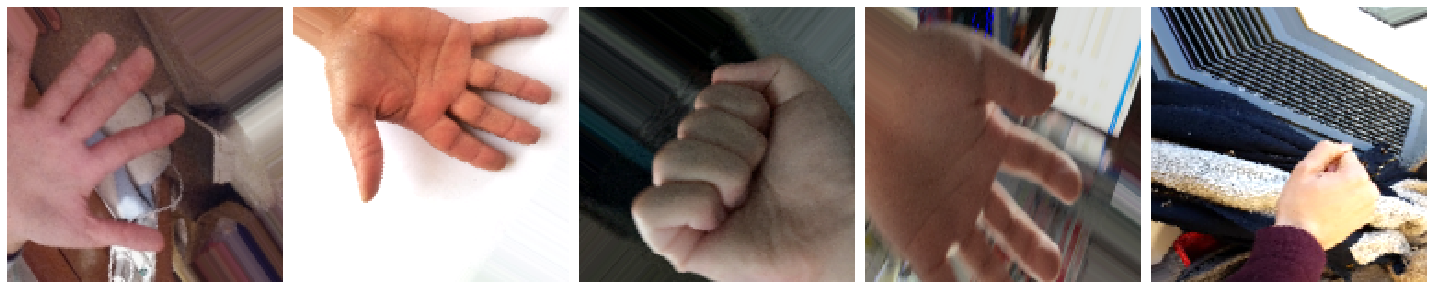

In [8]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# show training data
plotImages(sample_training_images[:5])

In [9]:

model= Sequential([
    Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.01), input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    #BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, 3, padding='same', activation=LeakyReLU(alpha=0.01)),
    #BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(rate=0.2),

    Conv2D(128, 3, padding='same', activation=LeakyReLU(alpha=0.01)),
    #BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(rate=0.2),
    
    Flatten(),
    Dropout(rate=0.2),
    Dense(512, activation=LeakyReLU(alpha=0.01)),
    Dense(1)
])
# maybe adding , activation='sigmoid' in last layer will be a good idea
# try use batch normalization between convolution
# Only use dropout on fully-connected layers
# https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html
# https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2
model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 247 steps, validate for 62 steps
Epoch 1/50
246/247 [============================>.] - ETA: 2s - loss: 0.6027 - accuracy: 0.6912
Epoch 00001: saving model to D:/model_checkpoints/training_8_LeakyRelu/v2KAKE01.ckpt
247/247 [==============================] - 754s 3s/step - loss: 0.6020 - accuracy: 0.6920 - val_loss: 0.5333 - val_accuracy: 0.7651
Epoch 2/50
246/247 [============================>.] - ETA: 2s - loss: 0.5343 - accuracy: 0.7387
Epoch 00002: saving model to D:/model_checkpoints/training_8_LeakyRelu/v2KAKE02.ckpt
247/247 [==============================] - 768s 3s/step - loss: 0.5340 - accuracy: 0.7392 - val_loss: 0.4706 - val_accuracy: 0.7470
Epoch 3/50
246/247 [============================>.] - ETA: 2s - loss: 0.4825 - accuracy: 0.7588
Epoch 00003: saving model to D:/model_checkpoints/training_8_LeakyRelu/v2KAKE03.ckpt
247/247 [===============

Epoch 26/50
246/247 [============================>.] - ETA: 2s - loss: 0.1713 - accuracy: 0.9271
Epoch 00026: saving model to D:/model_checkpoints/training_8_LeakyRelu/v2KAKE26.ckpt
247/247 [==============================] - 687s 3s/step - loss: 0.1712 - accuracy: 0.9271 - val_loss: 0.1176 - val_accuracy: 0.9647
Epoch 27/50
246/247 [============================>.] - ETA: 2s - loss: 0.1768 - accuracy: 0.9222
Epoch 00027: saving model to D:/model_checkpoints/training_8_LeakyRelu/v2KAKE27.ckpt
247/247 [==============================] - 697s 3s/step - loss: 0.1764 - accuracy: 0.9225 - val_loss: 0.1327 - val_accuracy: 0.9425
Epoch 28/50
246/247 [============================>.] - ETA: 2s - loss: 0.1775 - accuracy: 0.9294
Epoch 00028: saving model to D:/model_checkpoints/training_8_LeakyRelu/v2KAKE28.ckpt
247/247 [==============================] - 709s 3s/step - loss: 0.1773 - accuracy: 0.9294 - val_loss: 0.1499 - val_accuracy: 0.9254
Epoch 29/50
246/247 [============================>.] - ETA

ValueError: x and y must have same first dimension, but have shapes (50,) and (45,)

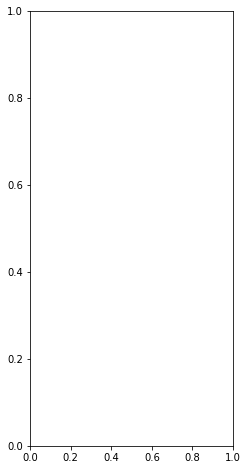

In [10]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = EarlyStopping(monitor='accuracy', patience=4, verbose=1,mode='max')


startTime= datetime.datetime.now()
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    class_weight=class_weights,
    #use_multiprocessing=True,
    #max_queue_size=50,
    #workers=8,
    callbacks=[early_stopping,cp_callback] #,tensorboard_callback
)

endTime= datetime.datetime.now()
# %tensorboard --logdir logs/fit

#not using tensorboard
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print("duration: {}".format(endTime-startTime))

In [ ]:
latest = tensorflow.train.latest_checkpoint(checkpoint_dir)
print(latest)


In [ ]:
## 
model.load_weights(latest)

test_data_gen = validation_image_generator.flow_from_directory(batch_size=30,
                                                              directory="D:/imageData/test",
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary'
                                                              )



test_data_gen.class_indices
# Re-evaluate the model

# loss,acc = model.evaluate(val_data_gen, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))


print("total number of fist test image is:{}".format(len(os.listdir("D:/imageData/test/fist/"))))
print("total number of palm test image is:{}".format(len(os.listdir("D:/imageData/test/palm/"))))

a,b=model.evaluate(test_data_gen)
print("\n lost:{}\n accuracy:{}".format(a,b))
